# Make plots for Yifei 

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from astropy.io import ascii
import os



import sys 
sys.path.append('..')
from functions import *
# from colormaps import new_colors
cmap = plt.get_cmap('tab10')
new_colors = cmap(range(10))

3.0rc2


In [7]:
run='UM_1'
config = parse_config('/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/config/mcmc_config_{0}.yaml'.format(str(run)))
config, cosmos_data, sim_data = initial_model(config)


5SHMR+scatter (Vmax@Mpeak)


In [8]:
config

{'config': 'UM_1',
 'cosmos_SMF_fit_file': 'cosmos2015_dic2017_smf_z01-04_STY0.dat',
 'cosmos_SMF_points_file': 'cosmos2015_dic2017_smf_z01-04_Vmax0_with_header.dat',
 'cosmos_catalog_reference': 'Laigle+2016',
 u'cosmos_cosmo': FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None),
 'cosmos_dir': 'cosmos/',
 'cosmos_dwarf_file': 'dwarf_sample_for_paper.fits',
 'cosmos_h0': 0.7,
 'cosmos_omega_m': 0.3,
 'cosmos_wl_file': 'dwarf_all_lens_laigle2015_nozp2.out',
 'data_location': '/Users/fardila/Documents/GitHub/dwarf_lensing/Data/',
 'frac_objects_with_specz': 0.167685,
 u'mcmc_backend_file': u'MCMC/outfiles/cosmos_bplanck_run_UM_1.hdf5',
 'mcmc_live_dangerously': True,
 'mcmc_moves': 'walk',
 'mcmc_ndims': 7,
 u'mcmc_npz_file': u'MCMC/outfiles/cosmos_bplanck_run_UM_1.npz',
 'mcmc_nsamples': 20000,
 'mcmc_nthreads': 1,
 'mcmc_nwalkers': 15,
 'mcmc_out_dir': 'MCMC/outfiles/',
 'mcmc_prefix': 'cosmos_bplanck',
 'mcmc_smf_only': False,
 'mcmc_stretch_a': 2.0,

In [104]:
config['sim_z']

0.278625

In [30]:
mass_bins = [8.0, 8.25, 8.5, 8.75, 9.0]

### DS for several mass bins

## create 4 files in 4 mass bins. take the average over 10 iterations in each bin 

In [38]:
def compute_deltaSigma_from_catalog(catalog, config, cosmos_data, sim_data):


    # select subsample of dwarfs from galaxy catalog
    # galaxies have the same positions as subhalos
    mock_galaxies = catalog['stellar_mass','halo_x', 'halo_y', 'halo_z']

    galaxies_table= mock_galaxies

    # read in galaxy positions
    x = galaxies_table['halo_x'] % config['sim_lbox']
    y = galaxies_table['halo_y'] % config['sim_lbox']
    z = galaxies_table['halo_z'] % config['sim_lbox']
    galaxies = np.vstack((x, y, z)).T

    # mass enclosed by cylinders around each galaxy
    period=np.ones(3)*config['sim_lbox']
    r_bins = np.logspace(-2.1,0,20)

    mass_encl = total_mass_enclosed_per_cylinder(galaxies, sim_data['particles'],
                                                 sim_data['particle_masses'],
                                                 sim_data['downsampling_factor'],
                                                 r_bins, period)

    # delta Sigma
    rp, ds = delta_sigma_from_precomputed_pairs(galaxies, mass_encl, r_bins,
                                                period, cosmology=config['sim_cosmo'])

    #convert to correct physical units
    ds = ds/1e12 # convert units pc^-2 --> Mpc^-2
    ds = ds*config['sim_h0']*((1+config['sim_z'])**2) #convert from comoving to physical
    rp = rp / float(config['sim_h0']*(1+config['sim_z'])) #convert from comoving to physical

    return rp, ds

def make_DS_catalog_given_params(params, run, config = None, cosmos_data = None, sim_data = None, write=False):

    if not config:
        config = parse_config('/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/config/mcmc_config_{0}.yaml'.format(str(run)))
        config, cosmos_data, sim_data = initial_model(config)

    halo_data = sim_data['halocat'].halo_table
    
    stellar_masses = get_chris_stellar_masses(params, config, sim_data)
    halo_data['stellar_mass'] = 10**stellar_masses
    
#     halo_data_reduced = halo_data['stellar_mass','halo_mpeak','halo_mvir','halo_Vmax@Mpeak', 'halo_upid']
    halo_data_reduced = halo_data
    
    if write:
        halo_data_reduced.write('/Users/fardila/Documents/GitHub/dwarf_lensing/mock_dwarfs/best_fit_mock_{0}.ascii'.format(run),
                  format ='ascii', overwrite=True, comment='#')
    
    return halo_data_reduced



In [30]:
best_UM_params = [ 0.31778976, 0.16864865, 2.76285812, 11.15042856,  0.12689323,  0.96288237, -0.03033116]

8.0 < M* < 8.25


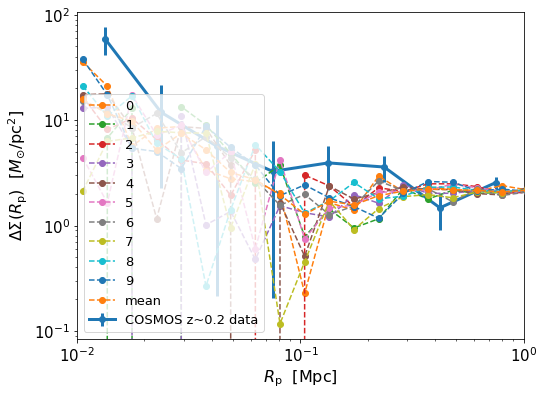

8.25 < M* < 8.5


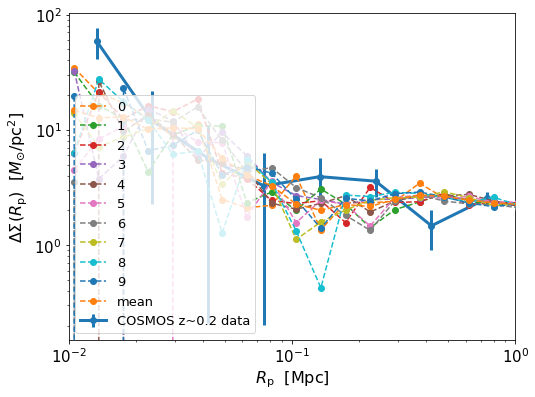

8.5 < M* < 8.75


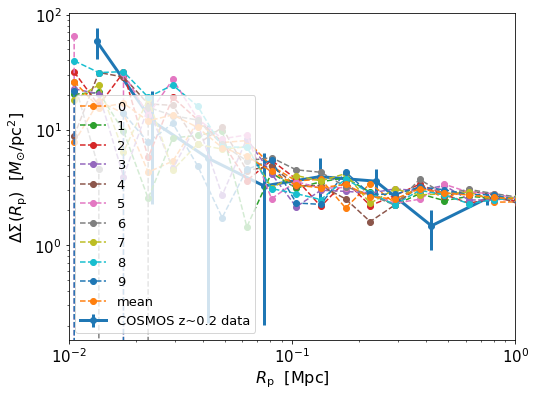

8.75 < M* < 9.0


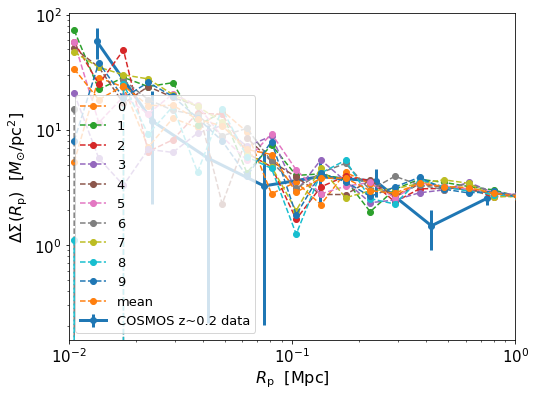

In [41]:

mean_ds_in_each_bin = []

for mass_index in range(4):
    lower_mass = mass_bins[mass_index]
    upper_mass = mass_bins[mass_index+1]
    print('{0} < M* < {1}'.format(lower_mass, upper_mass))
    
    wl_dss=[]
    labels=[]

    for i in range(10):
        # Predict DeltaSigma profiles
        catalog = make_DS_catalog_given_params(best_UM_params, 'UM_1',
                                        config = config, cosmos_data = cosmos_data, sim_data = sim_data,
                                        write=False)
        catalog = catalog[(np.log10(catalog['stellar_mass'])>7.8) & (np.log10(catalog['stellar_mass'])<9.2)]


        m_star_catalog = catalog[(np.log10(catalog['stellar_mass'])>lower_mass) \
                                       & (np.log10(catalog['stellar_mass'])<upper_mass)]

        wl_r, wl_ds = compute_deltaSigma_from_catalog(m_star_catalog, config, cosmos_data, sim_data)
        wl_dss.append(wl_ds)
        labels.append(str(i))

    wl_dss.append(np.mean(wl_dss, axis=0))
    labels.append('mean')
    plot_deltaSigma(cosmos_data['cosmos_wl_table'], np.array(wl_rs).T, np.array(wl_dss).T,
                       labels=labels)
    np.savetxt('/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/notebooks/model_WL_profile/UM_model_dwarfs_WL_profiles_10averaged_M*_{0}_{1}.txt'\
               .format(str(lower_mass),str(upper_mass)),
               np.c_[wl_r,wl_dss[-1]], header = 'R DS')
    mean_ds_in_each_bin.append(wl_dss[-1])



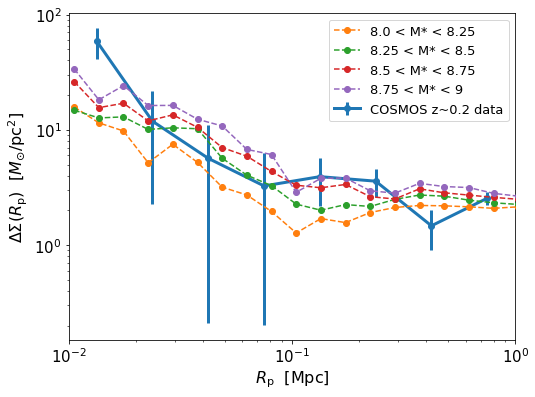

In [44]:
plot_deltaSigma(cosmos_data['cosmos_wl_table'], np.array(wl_rs[:4]).T, np.array(mean_ds_in_each_bin).T,
                       labels=['8.0 < M* < 8.25',
                              '8.25 < M* < 8.5',
                              '8.5 < M* < 8.75',
                              '8.75 < M* < 9.0'])